## Training target model


### Introduction

1. Pull the latest version of repository - to see, which models were already chosen by others.
2. Install new `requirements.txt`. It should work with python 3.12 and upgraded pip. It contains cuda tensrflow version. If you have problems with installation, try with `requirements-no-gpu.txt`.
3. Check, if tensorflow sees your graphics card.


In [1]:
# Source - https://stackoverflow.com/a
# Posted by Wilmar van Ommeren, modified by community. See post 'Timeline' for change history
# Retrieved 2026-01-18, License - CC BY-SA 4.0

import tensorflow as tf
tf.config.list_physical_devices('GPU')

2026-02-06 19:12:25.071876: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-06 19:12:25.113587: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-06 19:12:26.065323: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/jakseluz/miniconda3/envs/croada/lib/python3.12/site-packages/keras/src/exp

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

it should return something like:

```
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
```

4. Running model involves preparing GPU, downloading data and running appropriate training. Everything is described below.
5. And don't forget to push your name next to chosen model to repository!


#### Use the whole VRAM

Set VRAM size accoring to your GPU!!


In [2]:
from trainer.clipping_model import tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4000)] # Limit to 4000 MB of VRAM - TODO: adjust based on your GPU
        )
    except RuntimeError as e:
        print(e)

### Loading data and training model


Model training subsections are divided by grid density. Choose one model training subsection and then please clear cell outputs, **ADD your name in chosen model section header** and push this change on the repository. This should help us avoid conflicts, that 2 people will choose the same model.

So the header sholud like this:

```markdown
##### **GRZEGORZ** 1. Model - shallowed unet 256x256, grid density 1 m
```

#### trainer.random_fit_from_files() arguments

At the moment `epoch_steps` and `epochs` are set to 1. Run it and check, how long does it take to execute it. Then adjust these values to the amout of time you have. `epoch_steps` over 200 probably doesn't make sense, so later on increase just `epochs`.

If it lasts over 15 minutes, it means that probably there is some problem with graphics card. Nevertheless, it should run properly. Model is dumped to a different the file after each training and starts from the last checkpoint everytime, so don't hesitate to run it multiple times, if you want/have time to do it.


In [3]:
import os

data_dir = os.path.join("grids", "with-is-residential")

#### Grid density 1m


##### Downloading cities


If you have limited disk space, you can adjust `random_cities_count` variable, to download less city grids. It will save time and disk space, but will probably affect model training.
If you do this, please write somewhere down, which cities where used to train model - it will help when writing report.

> **Note:** It lasts for a while - for Częstochowa it is up to 20 minutes


In [ ]:
import random
from scraper.data_loader import DataLoader
from trainer.model import Model
from trainer.trainer import Trainer
import os
from pathlib import Path

random_cities_count = 11

folder_path = Path(data_dir)
folder_path.mkdir(parents=True, exist_ok=True)


# Prefered cities to download
cities = [
    ("Gdańsk, Polska", 466630),
    ("Bydgoszcz, Polska", 358928),
    ("Lublin, Polska", 339433),
    ("Gdynia, Polska", 246635),
    ("Radom, Polska", 214000),
    ("Toruń, Polska", 202074),
    ("Świętochłowice, Polska", 55_000),
    ("Koszalin, Polska", 108_000),
    ("Mielec, Polska", 59_000),
    ("Chorzów, Polska", 110_000),
    ("Rybnik, Polska", 140_000)
]

# List of Polish cities with population between 50,000 and 500,000
# cities = [
#     # ("Warsaw, Polska", 1790658),
#     # ("Kraków, Polska", 780981),
#     # ("Łódź, Polska", 687702),
#     # ("Wrocław, Polska", 640648),
#     # ("Poznań, Polska", 538633),
#     # ("Gdańsk, Polska", 466630),
#     ("Szczecin, Polska", 402465),
#     # ("Bydgoszcz, Polska", 358928),
#     ("Lublin, Polska", 339433),
#     ("Białystok, Polska", 297459),
#     ("Katowice, Polska", 294510),
#     # ("Gdynia, Polska", 246635),
#     ("Częstochowa, Polska", 224000),
#     ("Radom, Polska", 214000),
#     ("Toruń, Polska", 202074),
#     ("Kielce, Polska", 200000),
#     ("Rzeszów, Polska", 196000),
#     ("Opole, Polska", 128000),
#     ("Gliwice, Polska", 180000),
#     ("Zabrze, Polska", 170000),
#     ("Elbląg, Polska", 120000),
#     ("Płock, Polska", 120000),
#     ("Nowy Sącz, Polska", 85_000),
#     ("Słupsk, Polska", 91_000),
#     # ("Świętochłowice, Polska", 55_000),
#     ("Jelenia Góra, Polska", 79_000),
#     ("Stalowa Wola, Polska", 75_000),
#     # ("Koszalin, Polska", 108_000),
#     ("Mielec, Polska", 59_000),
#     ("Legnica, Polska", 100_000),
#     ("Tychy, Polska", 130_000),
#     ("Chorzów, Polska", 110_000),
#     # ("Rybnik, Polska", 140_000)
# ]

# Randomly select 8 cities
random_cities = random.sample(cities, random_cities_count)

loader = DataLoader(1, 5000, 5000, data_dir=data_dir, input_third_dimension=3)
managers = []
files = []

for city, population in random_cities:
    file_name = city.replace(", ", "-") + ".city_grid"
    print(f"Loading grid of city: {city} to {os.path.join(data_dir, file_name)}")
    manager = loader.load_city_grid(city,file_name)
    files.append(file_name)
    managers.append(manager)
    loader.add_elevation_to_grid(manager)
    loader.add_residential_to_grid(manager)

Version used by Jakub in "only is_street" dimension in input data model training tests - below:

In [ ]:
import random
from scraper.data_loader import DataLoader
from trainer.model import Model
from trainer.trainer import Trainer
import os
from pathlib import Path

random_cities_count = 11

folder_path = Path(data_dir)
folder_path.mkdir(parents=True, exist_ok=True)


# Prefered cities to download
cities = [
    ("Gdańsk, Polska", 466630),
    ("Bydgoszcz, Polska", 358928),
    ("Lublin, Polska", 339433),
    ("Gdynia, Polska", 246635),
    ("Radom, Polska", 214000),
    ("Toruń, Polska", 202074),
    ("Świętochłowice, Polska", 55_000),
    ("Koszalin, Polska", 108_000),
    ("Mielec, Polska", 59_000),
    ("Chorzów, Polska", 110_000),
    ("Rybnik, Polska", 140_000)
]


random_cities = random.sample(cities, random_cities_count)

loader = DataLoader(1, 5000, 5000, data_dir=data_dir, input_third_dimension=3) # not =1 because it does not work then
managers = []
files = []

for city, population in random_cities:
    file_name = city.replace(", ", "-") + ".city_grid"
    print(f"Loading grid of city: {city} to {os.path.join(data_dir, file_name)}")
    manager = loader.load_city_grid(city,file_name)
    files.append(file_name)
    managers.append(manager)
    #loader.add_elevation_to_grid(manager)
    #loader.add_residential_to_grid(manager)

In [ ]:
import math
import numpy as np
from grid_manager import GridManager


def add_zero_dimension_third_channel(grid_manager: GridManager, dimension_index: int):
    meta = grid_manager.get_metadata()

    segments_rows = math.ceil(meta.rows_number / meta.segment_h)
    segments_cols = math.ceil(meta.columns_number / meta.segment_w)

    for row_idx in range(segments_rows):
        for col_idx in range(segments_cols):
            segment = grid_manager.read_segment(row_idx, col_idx)

            h, w, _ = segment.shape

            for y in range(h):
                for x in range(w):
                    segment[y, x, dimension_index] = 0

            grid_manager.write_segment(segment, row_idx, col_idx)

            print(f"Segment [{row_idx}, {col_idx}] saved. Max value in dimension {dimension_index}: {np.max(segment[:, :, dimension_index]):.2f}")

In [ ]:
from grid_manager import GridManager
from pathlib import Path
import random

random_cities_count = 11

folder = Path(data_dir)
folder.mkdir(parents=True, exist_ok=True)
files = [GridManager(f.name, data_dir=data_dir) for f in folder.iterdir() if f.is_file()]
print(f"files: {files}")

cities = [
    ("Gdańsk, Polska", 466630),
    ("Bydgoszcz, Polska", 358928),
    ("Lublin, Polska", 339433),
    ("Gdynia, Polska", 246635),
    ("Radom, Polska", 214000),
    ("Toruń, Polska", 202074),
    ("Świętochłowice, Polska", 55_000),
    ("Koszalin, Polska", 108_000),
    ("Mielec, Polska", 59_000),
    ("Chorzów, Polska", 110_000),
    ("Rybnik, Polska", 140_000)
]

random_cities = random.sample(cities, random_cities_count)
for city, population in random_cities:
    file_name = city.replace(", ", "-") + ".city_grid"
    print(f"Loading grid of city: {city} to {os.path.join(data_dir, file_name)}")
    grid_manager = GridManager(file_name, data_dir=data_dir)
    add_zero_dimension_third_channel(grid_manager, dimension_index=1)
    add_zero_dimension_third_channel(grid_manager, dimension_index=2)

##### **GRZEGORZ** 1.1. Model - shallowed unet 256x256, grid density 1 m


In [ ]:
import os
from trainer.clipping_model import ClipModels, ClippingModel, tf
from trainer.trainer import Trainer
from pathlib import Path
from grid_manager import GridManager

model = ClippingModel(      # Define the model
    ClipModels.SHALLOWED_UNET,            # choose a model from ClipModels Enum (run the cell above to see possible models)
    clipping_size=256,          # size of the clipping (input to the model)
    clipping_surplus=64,        # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    path=os.path.join("models", "shallowed_unet_256_1m"),     # where to save the model

    input_third_dimension=4,
    output_third_dimension=3
)

folder = Path(data_dir)
files = [GridManager(f.name, data_dir=data_dir) for f in folder.iterdir() if f.is_file()]
print(f"files: {files}")

trainer = Trainer(          # Initialize the trainer with the model and data files
    model=model,                # the model defined above
    files=files
)

In [ ]:
trainer.random_fit_from_files(  # Train the model with random data from files
    epochs=1,                       # number of epochs to train
    steps_per_epoch=50,             # number of steps per epoch
    batch_size=8                   # size of each training batch
)
# after measuring step duration, adjust steps_per_epoch (max. around 200) and epochs to the amout of time you have

##### **JAKUB** 1.2. Model - shallowed unet 256x256, grid density 1 m - **no altitude**

In [4]:
import os
from trainer.clipping_model import ClipModels, ClippingModel, tf
from trainer.trainer import Trainer
from pathlib import Path
from grid_manager import GridManager

model = ClippingModel(      # Define the model
    model_type=ClipModels.SHALLOWED_UNET,            # choose a model from ClipModels Enum (run the cell above to see possible models)
    clipping_size=256,          # size of the clipping (input to the model)
    clipping_surplus=64,        # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    path=os.path.join("models", "shallowed_unet_256_1m_is_street_only"),     # where to save the model

    input_third_dimension=2,
    output_third_dimension=1
)

folder = Path(data_dir)
files = [GridManager(f.name, data_dir=data_dir) for f in folder.iterdir() if f.is_file()]
print(f"files: {files}")

trainer = Trainer(          # Initialize the trainer with the model and data files
    model=model,                # the model defined above
    files=files
)

I0000 00:00:1770401563.491741   30015 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4000 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1770401563.509182   30015 cuda_executor.cc:508] failed to allocate 3.91GiB (4194304000 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


files: [<grid_manager.GridManager object at 0x7f5712c63fe0>, <grid_manager.GridManager object at 0x7f5712c61730>, <grid_manager.GridManager object at 0x7f5712c63fb0>, <grid_manager.GridManager object at 0x7f5712c61700>, <grid_manager.GridManager object at 0x7f571ab10a10>, <grid_manager.GridManager object at 0x7f5712cf02f0>, <grid_manager.GridManager object at 0x7f5712cf04d0>, <grid_manager.GridManager object at 0x7f5712cf0560>, <grid_manager.GridManager object at 0x7f5712cf05f0>, <grid_manager.GridManager object at 0x7f5712cf0680>, <grid_manager.GridManager object at 0x7f5712cf0710>]


In [5]:
trainer.random_fit_from_files(  # Train the model with random data from files
    epochs=2,                       # number of epochs to train
    steps_per_epoch=100,             # number of steps per epoch
    batch_size=8                   # size of each training batch
)
# after measuring step duration, adjust steps_per_epoch (max. around 200) and epochs to the amout of time you have

Epoch 1/2


2026-02-06 19:12:50.769845: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f55fc01ab70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-06 19:12:50.769858: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2026-02-06 19:12:51.015226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-06 19:12:51.854009: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91800
2026-02-06 19:13:03.881454: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng19{k2=4} for conv (f16[64,3,3,192]{3,2,1,0}, u8[0]{0}) custom-call(f16[8,128,128,192]{3,2,1,0}, f16[8,128,128,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilt

  1/100 ━━━━━━━━━━━━━━━━━━━━ 40:31 25s/step - accuracy: 0.9879 - loss: 6.7493

I0000 00:00:1770401590.702887   30254 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.9848 - loss: 0.9695 - val_accuracy: 0.9885 - val_loss: 0.7718
Epoch 2/2
100/100 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.9858 - loss: 0.7250 - val_accuracy: 0.9820 - val_loss: 0.9074


##### 2. Model unet 256x256, grid density 1 m


In [ ]:
import os
from trainer.clipping_model import ClipModels, ClippingModel, tf
from trainer.trainer import Trainer
from pathlib import Path

model = ClippingModel(      # Define the model
    ClipModels.UNET,            # choose a model from ClipModels Enum (run the cell above to see possible models)
    clipping_size=256,          # size of the clipping (input to the model)
    clipping_surplus=64,        # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    path=os.path.join("models", "unet_256_1m")     # where to save the model
)

folder = Path(data_dir)
files = [GridManager(f.name, data_dir=data_dir) for f in folder.iterdir() if f.is_file()]
print(f"files: {files}")

trainer = Trainer(          # Initialize the trainer with the model and data files
    model=model,                # the model defined above
    files=files
)

In [ ]:
trainer.random_fit_from_files(  # Train the model with random data from files
    epochs=1,                       # number of epochs to train
    steps_per_epoch=1,             # number of steps per epoch
    batch_size=8                   # size of each training batch
)
# after measuring step duration, adjust steps_per_epoch (max. around 200) and epochs to the amout of time you have

##### **Jakub** 3. Model unet 512x512, grid density 1 m


In [ ]:
import os
from trainer.clipping_model import ClipModels, ClippingModel, tf
from trainer.trainer import Trainer
from pathlib import Path

model = ClippingModel(      # Define the model
    ClipModels.UNET,            # choose a model from ClipModels Enum (run the cell above to see possible models)
    clipping_size=512,          # size of the clipping (input to the model)
    clipping_surplus=128,        # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    path=os.path.join("models", "unet_512_1m")     # where to save the model
)

folder = Path(data_dir)
files = [GridManager(f.name, data_dir=data_dir) for f in folder.iterdir() if f.is_file()]
print(f"files: {files}")

trainer = Trainer(          # Initialize the trainer with the model and data files
    model=model,                # the model defined above
    files=files
)

In [ ]:
trainer.random_fit_from_files(  # Train the model with random data from files
    epochs=1,                       # number of epochs to train
    steps_per_epoch=1,             # number of steps per epoch
    batch_size=8                   # size of each training batch
)
# after measuring step duration, adjust steps_per_epoch (max. around 200) and epochs to the amout of time you have

#### Grid density 2 m


If you have limited disk space, you can adjust `random_cities_count` variable, to download less city grids. It will save time and disk space, but will probably affect model training.
If you do this, please write somewhere down, which cities where used to train model - it will help when writing report.

> **Note:** It lasts for a while - for Częstochowa it is up to 20 minutes


In [ ]:
import random
from scraper.data_loader import DataLoader
from trainer.model import Model
from trainer.trainer import Trainer
import os
from pathlib import Path

random_cities_count = 11

folder_path = Path(data_dir)
folder_path.mkdir(parents=True, exist_ok=True)


# Prefered cities to download
cities = [
    ("Gdańsk, Polska", 466630),
    ("Bydgoszcz, Polska", 358928),
    ("Lublin, Polska", 339433),
    ("Gdynia, Polska", 246635),
    ("Radom, Polska", 214000),
    ("Toruń, Polska", 202074),
    ("Świętochłowice, Polska", 55_000),
    ("Koszalin, Polska", 108_000),
    ("Mielec, Polska", 59_000),
    ("Chorzów, Polska", 110_000),
    ("Rybnik, Polska", 140_000)
]

# List of Polish cities with population between 50,000 and 500,000
# cities = [
#     # ("Warsaw, Polska", 1790658),
#     # ("Kraków, Polska", 780981),
#     # ("Łódź, Polska", 687702),
#     # ("Wrocław, Polska", 640648),
#     # ("Poznań, Polska", 538633),
#     # ("Gdańsk, Polska", 466630),
#     ("Szczecin, Polska", 402465),
#     # ("Bydgoszcz, Polska", 358928),
#     ("Lublin, Polska", 339433),
#     ("Białystok, Polska", 297459),
#     ("Katowice, Polska", 294510),
#     # ("Gdynia, Polska", 246635),
#     ("Częstochowa, Polska", 224000),
#     ("Radom, Polska", 214000),
#     ("Toruń, Polska", 202074),
#     ("Kielce, Polska", 200000),
#     ("Rzeszów, Polska", 196000),
#     ("Opole, Polska", 128000),
#     ("Gliwice, Polska", 180000),
#     ("Zabrze, Polska", 170000),
#     ("Elbląg, Polska", 120000),
#     ("Płock, Polska", 120000),
#     ("Nowy Sącz, Polska", 85_000),
#     ("Słupsk, Polska", 91_000),
#     # ("Świętochłowice, Polska", 55_000),
#     ("Jelenia Góra, Polska", 79_000),
#     ("Stalowa Wola, Polska", 75_000),
#     # ("Koszalin, Polska", 108_000),
#     ("Mielec, Polska", 59_000),
#     ("Legnica, Polska", 100_000),
#     ("Tychy, Polska", 130_000),
#     ("Chorzów, Polska", 110_000),
#     # ("Rybnik, Polska", 140_000)
# ]

# Randomly select 8 cities
random_cities = random.sample(cities, random_cities_count)

loader = DataLoader(2, 5000, 5000, data_dir=data_dir)
managers = []
files = []

for city, population in random_cities:
    file_name = city.replace(", ", "-") + ".city_grid"
    print(f"Loading grid of city: {city} to {os.path.join(data_dir, file_name)}")
    manager = loader.load_city_grid(city,file_name)
    files.append(file_name)
    managers.append(manager)
    loader.add_elevation_to_grid(manager)
    loader.add_residential_to_grid(manager)

##### 4. Model unet 256x256, grid density 2 m


In [ ]:
import os
from trainer.clipping_model import ClipModels, ClippingModel, tf
from trainer.trainer import Trainer
from pathlib import Path

model = ClippingModel(      # Define the model
    ClipModels.UNET,            # choose a model from ClipModels Enum (run the cell above to see possible models)
    clipping_size=256,          # size of the clipping (input to the model)
    clipping_surplus=64,        # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    path=os.path.join("models", "unet_256_2m")     # where to save the model
)

folder = Path(data_dir)
files = [GridManager(f.name, data_dir=data_dir) for f in folder.iterdir() if f.is_file()]
print(f"files: {files}")

trainer = Trainer(          # Initialize the trainer with the model and data files
    model=model,                # the model defined above
    files=files
)

In [ ]:
trainer.random_fit_from_files(  # Train the model with random data from files
    epochs=1,                       # number of epochs to train
    steps_per_epoch=1,             # number of steps per epoch
    batch_size=8                   # size of each training batch
)
# after measuring step duration, adjust steps_per_epoch (max. around 200) and epochs to the amout of time you have

##### 5. Model unet 512x512, grid density 2 m


In [ ]:
import os
from trainer.clipping_model import ClipModels, ClippingModel, tf
from trainer.trainer import Trainer
from pathlib import Path

model = ClippingModel(      # Define the model
    ClipModels.UNET,            # choose a model from ClipModels Enum (run the cell above to see possible models)
    clipping_size=512,          # size of the clipping (input to the model)
    clipping_surplus=128,        # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    path=os.path.join("models", "unet_512_2m")     # where to save the model
)

folder = Path(data_dir)
files = [GridManager(f.name, data_dir=data_dir) for f in folder.iterdir() if f.is_file()]
print(f"files: {files}")

trainer = Trainer(          # Initialize the trainer with the model and data files
    model=model,                # the model defined above
    files=files
)

In [ ]:
trainer.random_fit_from_files(  # Train the model with random data from files
    epochs=1,                       # number of epochs to train
    steps_per_epoch=1,             # number of steps per epoch
    batch_size=8                   # size of each training batch
)
# after measuring step duration, adjust steps_per_epoch (max. around 200) and epochs to the amout of time you have

### Evaluation

In [ ]:
import os
from trainer.clipping_model import ClipModels, ClippingModel, tf
from trainer.trainer import Trainer
from pathlib import Path
from grid_manager import GridManager

model = ClippingModel(      # Define the model
    ClipModels.SHALLOWED_UNET,            # choose a model from ClipModels Enum (run the cell above to see possible models)
    clipping_size=256,          # size of the clipping (input to the model)
    clipping_surplus=64,        # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    path=os.path.join("models", "shallowed_unet_256_1m"),     # where to save the model
    input_third_dimension=4,
    output_third_dimension=3
)

# folder = Path(data_dir)
# files = [GridManager(f.name, data_dir=data_dir) for f in folder.iterdir() if f.is_file()]
# print(f"files: {files}")

# trainer = Trainer(          # Initialize the trainer with the model and data files
#     model=model,                # the model defined above
#     files=files
# )

In [ ]:
from grid_manager import GridManager
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from trainer.model import PREDICT_GRID_INDICES


grid_manager = GridManager("Bydgoszcz-Polska.city_grid", data_dir="grids/with-is-residential")
metadata = grid_manager.get_metadata()

assert metadata.third_dimension_size == 3, "You have an outdated version of GridManager. Consider downloading grid files again to get all data..."

fragment_row, fragment_col = 2500, 2500
fragment_height, fragment_width = 1500, 1500

segment_h, segment_w = metadata.segment_h, metadata.segment_w
being_predicted = GridManager(
    f"test_{time.time()}.city_grid",
    fragment_height, fragment_width,
    0,0,
    metadata.grid_density,
    segment_h, segment_w,
    data_dir="grids/evaluation",
    third_dimension_size=model.input_third_dimension
)
# read_arbitrary_fragment does not take care of memory size - if there are some problems - just use smaller fragment
# Add IS_PREDICTED
tmp = np.ones((fragment_height, fragment_width, model.input_third_dimension))
tmp[
    :, :,
    1:model.input_third_dimension
] = grid_manager.read_arbitrary_fragment(fragment_row, fragment_col, fragment_height, fragment_width)[
    :, :,
    :model.input_third_dimension - 1
]

being_predicted.write_arbitrary_fragment(
    tmp,
    0, 0
) # for instance some segment in the middle

result = model.predict(being_predicted)
img = result.read_arbitrary_fragment(
    0, 0,
    fragment_height - model.get_input_grid_surplus(),
    fragment_width - model.get_input_grid_surplus()
)[:, :, PREDICT_GRID_INDICES.IS_STREET]

print(f"DEBUG: img.max(): {img.max()}")

struct_el = np.ones((3,3))
dilated = cv2.dilate(img, struct_el, iterations=3)
plt.gray()
plt.imshow(dilated)

In [ ]:
plt.imshow(img)

In [ ]:
fragment_row, fragment_col = 2000, 2000
fragment_height, fragment_width = 3000, 3000

segment_h, segment_w = metadata.segment_h, metadata.segment_w

# read_arbitrary_fragment does not take care of memory size - if there are some problems - just use smaller fragment
displayed = grid_manager.read_arbitrary_fragment(fragment_row, fragment_col, fragment_height, fragment_width)
print(f"displayed: {displayed.shape}")

plt.gray()
plt.imshow(displayed[:, :, 0], cmap="gray")

Version used by Jakub in "only is_street" dimension in input data model training tests - below:

In [6]:
import os
from trainer.clipping_model import ClipModels, ClippingModel, tf
from trainer.trainer import Trainer
from pathlib import Path
from grid_manager import GridManager

model = ClippingModel(
    ClipModels.SHALLOWED_UNET,
    clipping_size=256,
    clipping_surplus=64,
    path=os.path.join("models", "shallowed_unet_256_1m_is_street_only"),
    input_third_dimension=2,
    output_third_dimension=1
)

Starting from file: models/shallowed_unet_256_1m_is_street_only/1770402047_model.keras


DEBUG: input.third_dimension_size: 2

row: 0

2026-02-06 19:24:46.232863: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


........
row: 1........
row: 2........
row: 3........
row: 4........
row: 5........
row: 6........
row: 7........DEBUG: img.max(): 0.004070281982421875


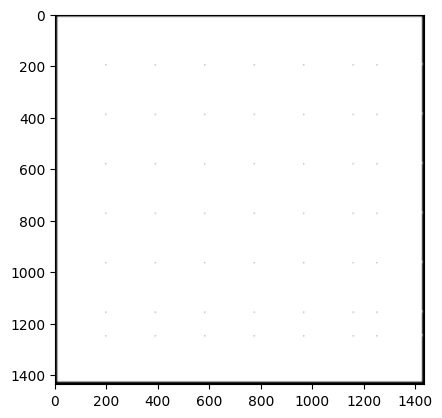

In [8]:
from grid_manager import GridManager
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from trainer.model import PREDICT_GRID_INDICES


grid_manager = GridManager("Bydgoszcz-Polska.city_grid", data_dir="grids/with-is-residential")
metadata = grid_manager.get_metadata()

assert metadata.third_dimension_size == 3, "You have an outdated version of GridManager. Consider downloading grid files again to get all data..."

fragment_row, fragment_col = 2500, 2500
fragment_height, fragment_width = 1500, 1500

segment_h, segment_w = metadata.segment_h, metadata.segment_w
being_predicted = GridManager(
    f"test_{time.time()}.city_grid",
    fragment_height, fragment_width,
    0,0,
    metadata.grid_density,
    segment_h, segment_w,
    data_dir="grids/evaluation",
    third_dimension_size=model.input_third_dimension
)
# read_arbitrary_fragment does not take care of memory size - if there are some problems - just use smaller fragment

crop = model.get_input_grid_surplus() // 2  # zwykle input_surplus/2

# Add IS_PREDICTED
tmp = np.zeros((fragment_height, fragment_width, model.input_third_dimension))

tmp[
    :, :, 1
] = grid_manager.read_arbitrary_fragment(fragment_row, fragment_col, fragment_height, fragment_width)[
    :, :, 0
].astype(np.float32)

# 2) ustaw maskę: przewidujemy tylko środek
tmp[:, :, 0] = 0.0
tmp[crop:fragment_height-crop, crop:fragment_width-crop, 0] = 1.0

# (opcjonalnie) możesz ręcznie wyzerować środek, ale jeśli predict() woła clean_input(), to nie jest konieczne:
# tmp[crop:fragment_height-crop, crop:fragment_width-crop, 1] = 0.0

being_predicted.write_arbitrary_fragment(
    tmp,
    0, 0
) # for instance some segment in the middle

result = model.predict(being_predicted)
img = result.read_arbitrary_fragment(
    0, 0,
    fragment_height - model.get_input_grid_surplus(),
    fragment_width - model.get_input_grid_surplus()
)[:, :, PREDICT_GRID_INDICES.IS_STREET]

print(f"DEBUG: img.max(): {img.max()}")

struct_el = np.ones((3,3))
dilated = cv2.dilate(img, struct_el, iterations=3)
plt.gray()
plt.imshow(dilated)

old version:

In [ ]:
from grid_manager import GridManager
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from trainer.model import PREDICT_GRID_INDICES


grid_manager = GridManager("Bydgoszcz-Polska.city_grid", data_dir="grids/with-is-residential")
metadata = grid_manager.get_metadata()

assert metadata.third_dimension_size == 3, "You have an outdated version of GridManager. Consider downloading grid files again to get all data..."

fragment_row, fragment_col = 2500, 2500
fragment_height, fragment_width = 1500, 1500

segment_h, segment_w = metadata.segment_h, metadata.segment_w
being_predicted = GridManager(
    f"test_{time.time()}.city_grid",
    fragment_height, fragment_width,
    0,0,
    metadata.grid_density,
    segment_h, segment_w,
    data_dir="grids/evaluation",
    third_dimension_size=2
)
# read_arbitrary_fragment does not take care of memory size - if there are some problems - just use smaller fragment
displayed = grid_manager.read_arbitrary_fragment(fragment_row, fragment_col, fragment_height, fragment_width)
print(f"displayed: {displayed.shape}")

being_predicted.write_arbitrary_fragment(
    grid_manager.read_arbitrary_fragment(fragment_row, fragment_col, fragment_height, fragment_width)[:, :, :2],
    0, 0
) # for instance some segment in the middle

result = model.predict(being_predicted)
img = result.read_arbitrary_fragment(
    0, 0,
    fragment_height - model.get_input_grid_surplus(),
    fragment_width - model.get_input_grid_surplus()
)[:, :, PREDICT_GRID_INDICES.IS_STREET]

print(f"DEBUG: img.max(): {img.max()}")

struct_el = np.ones((3,3))
dilated = cv2.dilate(img, struct_el, iterations=3)
plt.gray()
plt.imshow(dilated)

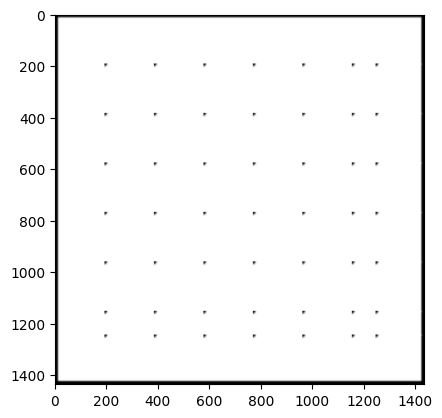

In [9]:
plt.imshow(img)

In [ ]:
fragment_row, fragment_col = 2000, 2000
fragment_height, fragment_width = 3000, 3000

segment_h, segment_w = metadata.segment_h, metadata.segment_w

# read_arbitrary_fragment does not take care of memory size - if there are some problems - just use smaller fragment
displayed = grid_manager.read_arbitrary_fragment(fragment_row, fragment_col, fragment_height, fragment_width)
print(f"displayed: {displayed.shape}")

plt.gray()
plt.imshow(displayed[:, :, 0], cmap="gray")

## Examples of modules usages


### Download mesh and get grid from OSM


In [ ]:
from scraper.data_loader import DataLoader
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [ ]:
# IMPORTANT!! - dataloader checks, if the file already exists
from scraper.data_loader import DataLoader

cityname = "Kraków"

loader = DataLoader(1)

grid_manager = loader.load_city_grid(cityname, cityname + ".dat")
# loader.add_elevation_to_grid(grid_manager)
loader.add_residential_to_grid(grid_manager)

#### Display downloaded grid (dilated to be better visible)


In [ ]:
from grid_manager import GridManager
import matplotlib.pyplot as plt
import cv2
import numpy as np

grid_manager = GridManager("Tychy.dat", data_dir="grids")
img = grid_manager.read_segment(2,0)[:5000, :5000, 0]

struct_el = np.ones((3,3))
dilated = cv2.dilate(img, struct_el, iterations=3)
plt.gray()
plt.imshow(dilated)

#### Adding is residential tests


In [ ]:
# IMPORTANT!! - dataloader checks, if the file already exists
from scraper.data_loader import DataLoader

cityname = "Tychy"

loader = DataLoader(1)

grid_manager = loader.load_city_grid(cityname, cityname + ".dat")
# loader.add_elevation_to_grid(grid_manager)
loader.add_residential_to_grid(grid_manager)


In [ ]:
from grid_manager import GridManager
from scraper.rasterizer import Rasterizer 
import matplotlib.pyplot as plt
import math

grid_manager = GridManager("Toruń.dat")
meta = grid_manager.get_metadata()
segments_rows = math.ceil(meta.rows_number / meta.segment_h)
segments_cols = math.ceil(meta.columns_number / meta.segment_w)


rasterizer = Rasterizer()
fig, axes = plt.subplots(segments_rows, segments_cols)
fig.set_size_inches((16, 16))
axes = axes.flatten()
axes_index = 0

for row_idx in range(segments_rows):
    for col_idx in range(segments_cols):
        segment = grid_manager.read_segment(row_idx, col_idx)

        axes[axes_index].imshow(segment[:, :, 2], cmap="gray")
        axes[axes_index].set_title(f"Segment_rows: {row_idx}, segment_cols: {col_idx}")
        axes_index += 1

In [ ]:
from grid_manager import GridManager
from scraper.rasterizer import Rasterizer 
import matplotlib.pyplot as plt
import math

grid_manager = GridManager("Toruń.dat")
meta = grid_manager.get_metadata()
segments_rows = math.ceil(meta.rows_number / meta.segment_h)
segments_cols = math.ceil(meta.columns_number / meta.segment_w)


rasterizer = Rasterizer()
fig, axes = plt.subplots(segments_rows, segments_cols)
fig.set_size_inches((16, 16))
axes = axes.flatten()
axes_index = 0

for row_idx in range(segments_rows):
    for col_idx in range(segments_cols):
        segment = grid_manager.read_segment(row_idx, col_idx)

        axes[axes_index].imshow(segment[:, :, 0], cmap="gray")
        axes[axes_index].set_title(f"Segment_rows: {row_idx}, segment_cols: {col_idx}")
        axes_index += 1


In [ ]:
from grid_manager import GridManager

grid_manager = GridManager("Tychy.dat")
img = grid_manager.read_segment(1,1)[:2000, :2000, 0]

fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle("Obrazki dróg (zdylatowane, żeby było lepiej widać)")

imgs = [
    [grid_manager.read_segment(0,0)[3000:, 3000:, 0], grid_manager.read_segment(0,1)[3000:, :2000, 0]],
    [grid_manager.read_segment(1,0)[:2000, 3000:, 0], grid_manager.read_segment(1,1)[:2000, :2000, 0]]
]

dilated_imgs = []

struct_el = np.ones((3,3))

for imgs_row in imgs:
    target_row = []
    dilated_imgs.append(target_row)
    for img in imgs_row:
        target_row.append(cv2.dilate(img, struct_el, iterations=3))

plt.gray()
axs[0,0].imshow(dilated_imgs[0][0])
axs[0,1].imshow(dilated_imgs[0][1])
axs[1,0].imshow(dilated_imgs[1][0])
axs[1,1].imshow(dilated_imgs[1][1])

In [ ]:
from scraper.grid_builder import GridBuilder
import math
from scraper.rasterizer import Rasterizer
import matplotlib.pyplot as plt

city = "Tychy, Polska"
builder = GridBuilder()

gdf_edges = builder.get_city_roads(city)

rasterizer = Rasterizer()

grid_2d = rasterizer.get_rasterize_roads(gdf_edges, 1, is_residential=False)
plt.imshow(grid_2d, cmap="gray")
plt.title(f"City: {city}")

In [ ]:
from scraper.grid_builder import GridBuilder
import math
from scraper.rasterizer import Rasterizer
import matplotlib.pyplot as plt
import geopandas as gpd

city = "Kraków"
builder = GridBuilder()
grid_density = 1
segment_h = 5000
segment_w = 5000
data_dir = "grids"

gdf_edges = builder.get_city_roads(city)
min_x, min_y, max_x, max_y = gdf_edges.total_bounds

columns_number = math.ceil((max_x - min_x) / grid_density)
rows_number = math.ceil((max_y - min_y) / grid_density)

segment_rows = math.ceil((rows_number) / segment_h)
segment_cols = math.ceil((columns_number) / segment_h)

# grid_manager = GridManager(file_name, rows_number=int(rows_number), columns_number=int(columns_number),
#                             grid_density=grid_density, segment_h=segment_h, segment_w=segment_w,
#                             data_dir=data_dir, upper_left_longitude=min_x, upper_left_latitude=max_y)
print(f"Height: {int(rows_number)}, Width: {int(columns_number)}, rows: {segment_rows}, cols: {segment_cols}")

rasterizer = Rasterizer()
fig, axes = plt.subplots(segment_rows, segment_cols)
fig.set_size_inches((16, 16))
axes = axes.flatten()
axes_index = 0
# single_row_gdf = gdf_edges.sample(1)

# grid_2d = rasterizer.rasterize_segment_from_indexes(gdf_edges=single_row_gdf, indexes=(0, 0), is_residential=False
#                                                             size_h=segment_h, size_w=segment_w,
#                                                             pixel_size=grid_density)
# print(grid_2d.shape)
# plt.imshow(grid_2d, cmap="gray")

for i in range(segment_rows):
    for j in range(segment_cols):
        grid_2d = rasterizer.rasterize_segment_from_indexes(gdf_edges=gdf_edges, indexes=(i, j), is_residential=False,
                                                            size_h=segment_h, size_w=segment_w,
                                                            pixel_size=grid_density)
        axes[axes_index].imshow(grid_2d, cmap="gray")
        axes[axes_index].set_title(f"Segment_rows: {i}, segment_cols: {j}")
        axes_index += 1

### Data management


In [ ]:
from grid_manager import GridManager
import numpy as np

filename = "przyklad1.dat"

src_man = GridManager(filename, 2000, 2000, 0.0, 0.0, 1, 3, 3, data_dir="grids")

# a = np.zeros((2000, 2000, 2), dtype=np.float64)
is_street = np.array([
    [1, 2, 3, 4, 5, 6],
    [11, 12, 13, 14, 15, 16],
    [21, 22, 23, 24, 25, 26],
    [31, 32, 33, 34, 35, 36],
    [41, 42, 43, 44, 45, 46],
    [51, 52, 53, 54, 55, 56],
])
a = np.zeros((is_street.shape[0], is_street.shape[1], 3))
a[:,:, 0] = is_street

for x in range(2):
    for y in range(2):
        src_man.write_segment(a[y * 3: (y + 1) * 3, x*3:(x + 1) * 3], y, x)


src_man.write_segment(a[:2,:3, :] + 1, 666, 0)
src_man.write_segment(a[:3,:2, :] + 2, 0, 666)

man = src_man.deep_copy()

print(f"1: {man.read_segment(0, 0)[:, :, 0]}")
print(f"2: {man.read_segment(0, 1)[:, :, 0]}")
print(f"3: {man.read_segment(1, 0)[:, :, 0]}")
print(f"4: {man.read_segment(1, 1)[:, :, 0]}")
print(f"5: {man.read_segment(666, 666)[:, :, 0]}")

print(man.get_metadata())

man.delete()


### Streets discovery


In [ ]:
import matplotlib.pyplot as plt

def show_crossroads(img_height, img_width, conflictless_crossroads, conflicting_crossroads):
    fig, axs = plt.subplots(  max(2, len(conflictless_crossroads), len(conflicting_crossroads)), 6, figsize=(10,5))
    axs[0, 0].set_title("conflictless")
    axs[0, 1].set_title("junctions")
    axs[0, 2].set_title("conflicts")
    axs[0, 3].set_title("conflicting")
    axs[0, 4].set_title("junctions")
    axs[0, 5].set_title("conflicts")


    for i in range(len(conflictless_crossroads)):
        crossroad = conflictless_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.points:
            crossroad_image[point] = 1

        axs[i, 0].imshow(crossroad_image)

    for i in range(len(conflictless_crossroads)):
        crossroad = conflictless_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for street in crossroad.street_junctions.keys():
            crossroad_image[crossroad.street_junctions[street]] = 1

        axs[i, 1].imshow(crossroad_image)

    for i in range(len(conflictless_crossroads)):
        crossroad = conflictless_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.conflicting_points:
            crossroad_image[point] = 1

        axs[i, 2].imshow(crossroad_image)

    for i in range(len(conflicting_crossroads)):
        crossroad = conflicting_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.points:
            crossroad_image[point] = 1

        axs[i, 3].imshow(crossroad_image)

    for i in range(len(conflicting_crossroads)):
        crossroad = conflicting_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for street in crossroad.street_junctions.keys():
            crossroad_image[crossroad.street_junctions[street]] = 1

        axs[i, 4].imshow(crossroad_image)

    for i in range(len(conflicting_crossroads)):
        crossroad = conflicting_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.conflicting_points:
            crossroad_image[point] = 1

        axs[i, 5].imshow(crossroad_image)


In [ ]:
import matplotlib.pyplot as plt

def show_streets(img_height, img_width, conflictless_streets, conflicting_streets):
    fig, axs = plt.subplots(  max(2, len(conflictless_streets), len(conflicting_streets)), 4, figsize=(10,8))
    axs[0, 0].set_title("conflictless")
    axs[0, 1].set_title("conflicts")
    axs[0, 2].set_title("conflicting")
    axs[0, 3].set_title("conflicts")


    for i in range(len(conflictless_streets)):
        street = conflictless_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.linestring:
            street_image[point] = 1

        axs[i, 0].imshow(street_image)
    
    for i in range(len(conflictless_streets)):
        street = conflictless_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.conflicts:
            street_image[point] = 1

        axs[i, 1].imshow(street_image)

    for i in range(len(conflicting_streets)):
        street = conflicting_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.linestring:
            street_image[point] = 1

        axs[i, 2].imshow(street_image)
    
    for i in range(len(conflicting_streets)):
        street = conflicting_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.conflicts:
            street_image[point] = 1

        axs[i, 3].imshow(street_image)


#### Diamond


In [ ]:
import numpy as np
from skimage.morphology import skeletonize
from graph_remaker.morphological_remaker import discover_streets
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("test_images/diamond.png", cv2.IMREAD_GRAYSCALE)
plt.gray()
bin_image = image > 0
# plt.imshow(bin_image * 255)

processed_image = bin_image[:, :, np.newaxis]
processed_image = np.concatenate((processed_image, np.zeros(processed_image.shape)), axis=2)

conflictless_crossroads, conflicting_crossroads, conflictless_streets, conflicting_streets = discover_streets(processed_image)

height, width = image.shape
plt.imshow(image)

In [ ]:
show_crossroads(height, width, conflictless_crossroads, conflicting_crossroads)

In [ ]:
show_streets(height, width, conflictless_streets, conflicting_streets)

#### Conflicting crossroad and dead-end


In [ ]:
import numpy as np
from skimage.morphology import skeletonize
from graph_remaker.morphological_remaker import discover_streets
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("test_images/crossroad_conflict_deadend.png", cv2.IMREAD_GRAYSCALE)
plt.gray()
bin_image = image > 0
# plt.imshow(bin_image * 255)

processed_image = bin_image[:, :, np.newaxis]
processed_image = np.concatenate((processed_image, np.zeros(processed_image.shape)), axis=2)

conflictless_crossroads, conflicting_crossroads, conflictless_streets, conflicting_streets = discover_streets(processed_image)

height, width = image.shape
plt.imshow(image)

In [ ]:
show_crossroads(width, height, conflictless_crossroads, conflicting_crossroads)

In [ ]:
show_streets(width, height, conflictless_streets, conflicting_streets)

### Model training (tutorial, not used in practice anymore. For practical use, look at the higher entries in the notebook)


##### Use the whole VRAM


In [ ]:
from trainer.clipping_model import tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4000)] # Limit to 4000 MB of VRAM - TODO: adjust based on your GPU
        )
    except RuntimeError as e:
        print(e)

##### Create batch sequence of clippings that are the candidates for a model and print the shape of the input


In [ ]:
from trainer.clipping_sequence import ClippingBatchSequence # not used anymore in the project - only for visualisation
from trainer.batch_sequence import BatchSequence            # not used anymore in the project - only for visualisation

batchSeq = ClippingBatchSequence(           # Define a clipping batch sequence
            BatchSequence(                      # Define a batch sequence
                files=list(["Tychy.dat"]),          # list of files to use
                batch_size=1,                       # not important here
                cut_sizes=[(512, 512)],             # sizes of cuttings to make from the grid
            ),
            clipping_size=512,                  # size of the clipping (input to the model)
            input_grid_surplus=64,              # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
        )

X, Y = batchSeq[0]          # get the first batch
print("Shape of the input batch: ", X.shape)              # print the shape of the input batch

##### Display example clipping (X and y) - `WARNING: you may need to run the above code up to approx. 3-5 times in order to get an image below, other than a void one`


In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(X[0, :, :, 0], cmap='grey')
axs[1].imshow(Y["is_street"][0, :, :, 0], cmap='grey')

print("X min/max:", X[0, :, :, 0].min(), X[0, :, :, 0].max())
print("Y min/max:", Y["is_street"][0, :, :, 0].min(), Y["is_street"][0, :, :, 0].max())

##### Show available GPUs


In [ ]:
from tensorflow.python.client import device_lib
import tensorflow as tf

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

##### Define a model and then cities for the trainer (e.g. Tychy) as the files list


In [ ]:
from trainer.clipping_model import ClipModels       # Import ClipModels Enum

print("Possible models:")
for model in ClipModels:
    print(f"- {model.name}: {model.value}")

In [ ]:
from trainer.clipping_model import ClipModels, ClippingModel, tf
from trainer.trainer import Trainer

model = ClippingModel(      # Define the model
    ClipModels.BASE,            # choose a model from ClipModels Enum (run the cell above to see possible models)
    clipping_size=512,          # size of the clipping (input to the model)
    clipping_surplus=64,        # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    path="model_test_16_01"     # where to save the model
)
trainer = Trainer(          # Initialize the trainer with the model and data files
    model=model,                # the model defined above
    files=[                     # list of data files to use for training
        "Tychy.dat",
        # "Kraków.dat"
    ]
)

##### Run fitting which created the above batch sequence and trains the model

`random_fit_from_files(self, epochs: int = 100, steps_per_epoch=1000, batch_size=32)`


In [ ]:
trainer.random_fit_from_files(  # Train the model with random data from files
    epochs=1,                       # number of epochs to train
    steps_per_epoch=10,             # number of steps per epoch
    batch_size=32                   # size of each training batch
)

##### Other models etc.

You may need to run "Use the whole VRAM" cell before them (separately and probably after the kernel restart)


#### UNET


In [ ]:
from trainer.clipping_model import ClipModels, ClippingModel, tf
from trainer.trainer import Trainer

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

model = ClippingModel(
    ClipModels.UNET,
    clipping_size=512,
    clipping_surplus=64,
    path="model_test_13_01_13_22"
)
trainer = Trainer(
    model=model,
    files=[
        "Tychy.dat",
        "Kraków.dat"
    ]
)
# Na mojej laptopowej RTX 3050 Ti 4GB, batch_size=8 nie poradził sobie z pamięcią po 4 minutach.
# Zmieniłem batch_size na 2 i działa - 44 sekundy na poniższym przykładzie
# UPDATE: Zmieniłem na 4, działa dobrze
# - trochę ponad minuta po ustawieniu (w wyższej komórce) memory_limit=4000
trainer.random_fit_from_files(1, 10, batch_size=4)

#### AlexInspired


In [ ]:
from trainer.clipping_model import ClipModels, ClippingModel, tf
from trainer.trainer import Trainer

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

model = ClippingModel(
    ClipModels.ALEX_INSPIRED,
    clipping_size=256,
    clipping_surplus=32,
    path="model_test_13_01_13_22"
)
trainer = Trainer(
    model=model,
    files=[
        "Tychy.dat",
        "Kraków.dat"
    ]
)

# u mnie zajęło 41 minut i 1.1 sekundy
trainer.random_fit_from_files(1, 10, batch_size=4)

### upper algorithm


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import cv2
import numpy as np
import math
from shapely.geometry import LineString

# Upewnij się, że masz te importy dostępne w projekcie
from grid_manager import GridManager, GRID_INDICES
from graph_remaker.memory_wise import process_large_grid

# 1. KONFIGURACJA
H, W = 1000, 1000
SEG_SIZE = 200
TEMP_GRID_DIR = "grids"
TEMP_GRID_FILE = "square_test.dat"
FULL_PATH = os.path.join(TEMP_GRID_DIR, TEMP_GRID_FILE)

# Upewnij się, że katalog istnieje
os.makedirs(TEMP_GRID_DIR, exist_ok=True)

print(f"Generowanie obrazu {W}x{H}...")

# Tworzymy macierz 3-kanałową (zgodnie z oczekiwaniami memory_wise/morphological_remaker)
# Zazwyczaj: 0=IS_STREET, 1=ALTITUDE, 2=IS_ESTATE (lub podobnie)
full_grid = np.zeros((H, W, 3), dtype=np.float32)

# Tymczasowe płótno do rysowania kształtów (OpenCV operuje na uint8)
canvas = np.zeros((H, W), dtype=np.uint8)

# Rysujemy KWADRAT (linie prostopadłe do osi)
# Współrzędne: (150, 150) do (850, 850)
cv2.rectangle(canvas, (150, 150), (850, 850), 255, thickness=12)

# Dodajmy Krzyż w środku (skrzyżowanie 4-wylotowe)
cv2.line(canvas, (500, 150), (500, 850), 255, thickness=12) # Pion
cv2.line(canvas, (150, 500), (850, 500), 255, thickness=12) # Poziom

# Przepisanie do odpowiedniego kanału w Gridzie
# IS_STREET - maska binarna (0 lub 1)
full_grid[:, :, GRID_INDICES.IS_STREET] = (canvas > 0).astype(np.float32)

# ALTITUDE - zostawiamy 0.0 (płaski teren), żeby morphological_remaker nie wyrzucił błędu przy slope
full_grid[:, :, GRID_INDICES.ALTITUDE] = 0.0

print("Obraz wygenerowany.")

# 2. ZAPIS DO PLIKU POPRZEZ GRID MANAGER

# Używamy pełnej ścieżki tylko do sprawdzenia i usunięcia starego pliku
if os.path.exists(FULL_PATH):
    try:
        os.remove(FULL_PATH)
    except PermissionError:
        print(f"Nie można usunąć {FULL_PATH}, może jest otwarty? Próbuję nadpisać...")
    except Exception as e:
        print(f"Błąd przy usuwaniu pliku: {e}")

# Inicjalizacja Managera
# ZMIANA:
# 1. file_name = TEMP_GRID_FILE (samo "square_test.dat")
# 2. data_dir = TEMP_GRID_DIR ("grids")
# GridManager sam połączy to w "grids/square_test.dat"
gm = GridManager(file_name=TEMP_GRID_FILE,
                 rows_number=H,
                 columns_number=W,
                 upper_left_longitude=0.0,
                 upper_left_latitude=0.0,
                 grid_density=1.0,
                 segment_h=SEG_SIZE,
                 segment_w=SEG_SIZE,
                 data_dir=TEMP_GRID_DIR)

rows_n = math.ceil(H / SEG_SIZE)
cols_n = math.ceil(W / SEG_SIZE)

print(f"Zapisywanie segmentów ({rows_n}x{cols_n})...")

for r in range(rows_n):
    for c in range(cols_n):
        y_start = r * SEG_SIZE
        x_start = c * SEG_SIZE
        y_end = min(y_start + SEG_SIZE, H)
        x_end = min(x_start + SEG_SIZE, W)

        # Wycinamy fragment z pełnej siatki 3D
        chunk = full_grid[y_start:y_end, x_start:x_end, :]
        gm.write_segment(chunk, r, c)

print("Dane zapisane na dysku. Uruchamiam memory_wise...")

# 3. URUCHOMIENIE PRZETWARZANIA
try:
    print(f"Wczytywanie pliku: {TEMP_GRID_FILE} z domyślnego folderu 'grids'...")

    # ZMIANA: Przekazujemy tylko nazwę pliku ("square_test.dat"), a nie FULL_PATH.
    # GridManager wewnątrz tej funkcji sam dopisze sobie folder "grids/".
    graph = process_large_grid(TEMP_GRID_FILE)

    # 4. WIZUALIZACJA
    print(f"\n--- WYNIK ---")
    print(f"Węzły: {len(graph.nodes)}")
    print(f"Krawędzie: {len(graph.edges)}")

    plt.figure(figsize=(14, 7))

    # --- LEWA STRONA: Oryginalny obraz (Piksele) ---
    plt.subplot(1, 2, 1)
    plt.title(f"Wejście (Piksele {W}x{H})")
    plt.imshow(canvas, cmap='gray')

    # Siatka podziału na segmenty
    for y in range(0, H, SEG_SIZE):
        plt.axhline(y, color='yellow', linestyle='--', alpha=0.3)
    for x in range(0, W, SEG_SIZE):
        plt.axvline(x, color='yellow', linestyle='--', alpha=0.3)
    plt.xlabel("X [px]")
    plt.ylabel("Y [px]")

    # --- PRAWA STRONA: Zrekonstruowany Graf (Lat/Lon) ---
    plt.subplot(1, 2, 2)
    plt.title("Wyjście: Graf (Współrzędne Geograficzne)")

    if len(graph.nodes) > 0:
        # Rysowanie węzłów
        # Memory_wise konwertuje piksele na Lat/Lon.
        # node['x'] to Longitude, node['y'] to Latitude.
        node_positions = {n: (data['x'], data['y']) for n, data in graph.nodes(data=True)}

        # Rysowanie krawędzi (GeoPandas style - używając geometrii LineString)
        for u, v, data in graph.edges(data=True):
            if 'geometry' in data and isinstance(data['geometry'], LineString):
                # Jeśli mamy geometrię szczegółową (krzywe)
                xs, ys = data['geometry'].xy
                plt.plot(xs, ys, color='cyan', linewidth=2, alpha=0.7, zorder=1)
            else:
                # Fallback dla prostych linii
                p1 = node_positions[u]
                p2 = node_positions[v]
                plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='blue', linewidth=1, alpha=0.5, zorder=1)

        # Rysowanie punktów węzłów
        # Rozróżnienie kolorami: Skrzyżowania vs Łączniki
        crossroads = [n for n, d in graph.nodes(data=True) if d.get('type') == 'crossroad']
        connectors = [n for n, d in graph.nodes(data=True) if d.get('type') != 'crossroad']

        nx.draw_networkx_nodes(graph, node_positions, nodelist=crossroads, node_size=30, node_color='red', label='Crossroads')
        nx.draw_networkx_nodes(graph, node_positions, nodelist=connectors, node_size=10, node_color='orange', label='Connectors')

        plt.legend()
        plt.axis('equal')
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")

    else:
        plt.text(0.5, 0.5, "BRAK WYNIKÓW GRAFU", ha='center', color='red', fontsize=15)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"CRITICAL ERROR: {e}")
    import traceback
    traceback.print_exc()